# Lab 7: Approximating Expectations - Quadrature and Monte Carlo

This lab demonstrates numerical methods for approximating expectations in dynamic programming:
1. **Quadrature methods** (Gauss-Hermite, Gauss-Legendre)
2. **Monte Carlo methods** and variance reduction techniques



In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import roots_hermite, roots_legendre
import time

# Set random seed for reproducibility
np.random.seed(42)

# Plotting style
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11


---
## Part 1: Quadrature Methods

### 1.1 Defining Quadrature Functions

We want to approximate expectations of the form:
$$\mathbb{E}[V(s')]= \int V(s') p(s'|s) ds'$$

where $s' = \rho s + \varepsilon$ and $\varepsilon$ follows some distribution.

**Two main quadrature methods:**
- **Gauss-Hermite (GH)**: Optimal for Gaussian/Normal distributions
- **Gauss-Legendre (GL)**: Optimal for Uniform/Bounded distributions

**Test case**: Value function $V(s) = -s^2 + 2s$ with AR(1) process $s' = \rho s + \varepsilon$


In [3]:
# Define quadrature functions
def gauss_hermite_quadrature(mu, sigma, n_nodes=5):
    """
    Gauss-Hermite quadrature for N(mu, sigma^2).
    
    Returns nodes and weights such that:
    E[f(X)] ≈ sum(weights * f(nodes)) for X ~ N(mu, sigma^2)
    """
    x, w = roots_hermite(n_nodes)
    nodes = mu + np.sqrt(2) * sigma * x
    weights = w / np.sqrt(np.pi)
    return nodes, weights

def gauss_legendre_quadrature(a, b, n_nodes=5):
    """
    Gauss-Legendre quadrature for interval [a, b].
    
    Returns nodes and weights such that:
    - Integral: sum(weights * f(nodes)) ≈ ∫[a,b] f(x) dx
    - Expectation (uniform): sum(weights * f(nodes)) / (b-a) ≈ E[f(X)] for X ~ U[a,b]
    """
    x, w = roots_legendre(n_nodes)
    nodes = (b - a) / 2 * x + (a + b) / 2
    weights = w * (b - a) / 2
    return nodes, weights

# Define value function
def value_function(s):
    """Simple quadratic value function: V(s) = -s^2 + 2s"""
    return -s**2 + 2*s

# Model parameters
rho = 0.5        # AR(1) persistence parameter
s_current = 1.0  # Current state


### 1.2 Two Test Cases: Normal and Uniform Shocks

We will test both quadrature methods on two different shock distributions.

**Case 1: Normal Shock** $\varepsilon \sim N(0, \sigma^2)$

State evolution: $s' = \rho s + \varepsilon \sim N(\rho s, \sigma^2)$

Analytical solution for $V(s) = -s^2 + 2s$:
$$\mathbb{E}[V(s')] = \mathbb{E}[-(s')^2 + 2s'] = -\mathbb{E}[(s')^2] + 2\mathbb{E}[s']$$

Using $\mathbb{E}[(s')^2] = \text{Var}(s') + (\mathbb{E}[s'])^2$:
$$\mathbb{E}[V(s')] = -(\sigma^2 + (\rho s)^2) + 2\rho s$$

**Case 2: Uniform Shock** $\varepsilon \sim U[a, b]$

State evolution: $s' = \rho s + \varepsilon$ where $\varepsilon$ is uniformly distributed

Analytical solution for $V(s) = -s^2 + 2s$:
$$\mathbb{E}[V(s')] = \frac{1}{b-a}\int_a^b V(\rho s + \varepsilon) d\varepsilon$$

After integration:
$$\mathbb{E}[V(s')] = -(\rho s)^2 - \frac{(b-a)^2}{12} - (\rho s)(b+a) + 2\rho s + (b+a)$$


In [4]:
print("=" * 60)
print("Computing Analytical Solutions for Both Cases")
print("=" * 60)

# Case 1: Normal shock parameters
sigma_eps = 0.1
mean_s_next = rho * s_current
var_s_next = sigma_eps**2
true_expectation_normal = -(mean_s_next**2 + var_s_next) + 2*mean_s_next

print("\nCase 1: Normal Shock ε ~ N(0, σ²)")
print("-" * 40)
print(f"Parameters: σ = {sigma_eps}")
print(f"State next period: s' ~ N({mean_s_next}, {sigma_eps}²)")
print(f"True E[V(s')]: {true_expectation_normal:.10f}")

# Case 2: Uniform shock parameters
a_unif, b_unif = -0.2, 0.2
mean_eps = (a_unif + b_unif) / 2
var_eps = (b_unif - a_unif)**2 / 12
true_expectation_uniform = (-(rho * s_current)**2 - var_eps - (rho * s_current) * (b_unif + a_unif) 
                            + 2 * rho * s_current + (b_unif + a_unif))

print("\nCase 2: Uniform Shock ε ~ U[a, b]")
print("-" * 40)
print(f"Parameters: a = {a_unif}, b = {b_unif}")
print(f"State next period: s' = {rho}×{s_current} + ε")
print(f"True E[V(s')]: {true_expectation_uniform:.10f}")



Computing Analytical Solutions for Both Cases

Case 1: Normal Shock ε ~ N(0, σ²)
----------------------------------------
Parameters: σ = 0.1
State next period: s' ~ N(0.5, 0.1²)
True E[V(s')]: 0.7400000000

Case 2: Uniform Shock ε ~ U[a, b]
----------------------------------------
Parameters: a = -0.2, b = 0.2
State next period: s' = 0.5×1.0 + ε
True E[V(s')]: 0.7366666667


### 1.3 Comparing All Methods on Both Cases

Now let's test three approximation methods on both cases:
1. **Gauss-Hermite (GH)** - designed for Gaussian
2. **Gauss-Legendre (GL)** - designed for uniform  
3. **Brute-force discretization** - uniform grid

**Note**: GL computes integrals; divide by $(b-a)$ for expectations with uniform distributions.


In [5]:
def discretization_method(mu, sigma, n_points=100):
    """Approximate expectation using uniform grid discretization."""
    grid = np.linspace(mu - 4*sigma, mu + 4*sigma, n_points)
    dx = grid[1] - grid[0]
    pdf_values = stats.norm.pdf(grid, mu, sigma)
    weights = pdf_values * dx
    weights = weights / weights.sum()
    return grid, weights

# ============================================================
# TEST ON NORMAL SHOCK (Case 1)
# ============================================================
print("\n" + "=" * 70)
print("CASE 1: Normal Shock ε ~ N(0, σ²)")
print("=" * 70)
print(f"Parameters: σ = {sigma_eps}, s' ~ N({mean_s_next}, {sigma_eps}²)")
print(f"True E[V(s')]: {true_expectation_normal:.10f}\n")

n_test = 5  # Number of nodes/points for comparison

# Method 1: Gauss-Hermite (OPTIMAL for normal)
nodes_gh, weights_gh = gauss_hermite_quadrature(mean_s_next, sigma_eps, n_test)
E_V_gh_norm = np.sum(weights_gh * value_function(nodes_gh))
error_gh_norm = np.abs(E_V_gh_norm - true_expectation_normal)

# Method 2: Gauss-Legendre (SUBOPTIMAL for normal)
a_approx = mean_s_next - 3*sigma_eps
b_approx = mean_s_next + 3*sigma_eps
nodes_gl, weights_gl = gauss_legendre_quadrature(a_approx, b_approx, n_test)
pdf_at_nodes = stats.norm.pdf(nodes_gl, mean_s_next, sigma_eps)
weights_gl_reweighted = weights_gl * pdf_at_nodes * (b_approx - a_approx)
E_V_gl_norm = np.sum(weights_gl_reweighted * value_function(nodes_gl))
error_gl_norm = np.abs(E_V_gl_norm - true_expectation_normal)

# Method 3: Brute-force discretization (100 points)
grid, weights_disc = discretization_method(mean_s_next, sigma_eps, 100)
E_V_disc_norm = np.sum(weights_disc * value_function(grid))
error_disc_norm = np.abs(E_V_disc_norm - true_expectation_normal)

print(f"{'Method':<30} | {'Points':>7} | {'Approximation':>15} | {'Error':>12}")
print("-" * 75)
print(f"{'Gauss-Hermite (OPTIMAL)':<30} | {n_test:>7} | {E_V_gh_norm:>15.10f} | {error_gh_norm:>12.2e}")
print(f"{'Gauss-Legendre (SUBOPTIMAL)':<30} | {n_test:>7} | {E_V_gl_norm:>15.10f} | {error_gl_norm:>12.2e}")
print(f"{'Discretization (BASELINE)':<30} | {100:>7} | {E_V_disc_norm:>15.10f} | {error_disc_norm:>12.2e}")


CASE 1: Normal Shock ε ~ N(0, σ²)
Parameters: σ = 0.1, s' ~ N(0.5, 0.1²)
True E[V(s')]: 0.7400000000

Method                         |  Points |   Approximation |        Error
---------------------------------------------------------------------------
Gauss-Hermite (OPTIMAL)        |       5 |    0.7400000000 |     1.11e-16
Gauss-Legendre (SUBOPTIMAL)    |       5 |    0.4470727917 |     2.93e-01
Discretization (BASELINE)      |     100 |    0.7400091604 |     9.16e-06


In [6]:
# ============================================================
# TEST ON UNIFORM SHOCK (Case 2)
# ============================================================
print("\n" + "=" * 70)
print("CASE 2: Uniform Shock ε ~ U[a, b]")
print("=" * 70)
print(f"Parameters: a = {a_unif}, b = {b_unif}")
print(f"True E[V(s')]: {true_expectation_uniform:.10f}\n")

# Method 1: Gauss-Legendre (OPTIMAL for uniform)
nodes_gl_unif, weights_gl_unif = gauss_legendre_quadrature(a_unif, b_unif, n_test)
s_next_gl = rho * s_current + nodes_gl_unif
E_V_gl_unif = np.sum(weights_gl_unif * value_function(s_next_gl)) / (b_unif - a_unif)
error_gl_unif = np.abs(E_V_gl_unif - true_expectation_uniform)

# Method 2: Gauss-Hermite (SUBOPTIMAL for uniform)
mu_approx = mean_eps
sigma_approx = np.sqrt(var_eps)
nodes_gh_unif, weights_gh_unif = gauss_hermite_quadrature(mu_approx, sigma_approx, n_test)
# GH assumes normal which has tails outside [a,b]
nodes_gh_clipped = np.clip(nodes_gh_unif, a_unif, b_unif)
s_next_gh = rho * s_current + nodes_gh_clipped
E_V_gh_unif = np.sum(weights_gh_unif * value_function(s_next_gh))
error_gh_unif = np.abs(E_V_gh_unif - true_expectation_uniform)

# Method 3: Brute-force discretization (100 points)
# For uniform distribution, use uniform grid on [a, b]
grid_unif = np.linspace(a_unif, b_unif, 100)
dx_unif = (b_unif - a_unif) / 100
weights_disc_unif = np.ones(100) / 100  # Uniform weights
s_next_disc = rho * s_current + grid_unif
E_V_disc_unif = np.sum(weights_disc_unif * value_function(s_next_disc))
error_disc_unif = np.abs(E_V_disc_unif - true_expectation_uniform)

print(f"{'Method':<30} | {'Points':>7} | {'Approximation':>15} | {'Error':>12}")
print("-" * 75)
print(f"{'Gauss-Legendre (OPTIMAL)':<30} | {n_test:>7} | {E_V_gl_unif:>15.10f} | {error_gl_unif:>12.2e}")
print(f"{'Gauss-Hermite (SUBOPTIMAL)':<30} | {n_test:>7} | {E_V_gh_unif:>15.10f} | {error_gh_unif:>12.2e}")
print(f"{'Discretization (BASELINE)':<30} | {100:>7} | {E_V_disc_unif:>15.10f} | {error_disc_unif:>12.2e}")




CASE 2: Uniform Shock ε ~ U[a, b]
Parameters: a = -0.2, b = 0.2
True E[V(s')]: 0.7366666667

Method                         |  Points |   Approximation |        Error
---------------------------------------------------------------------------
Gauss-Legendre (OPTIMAL)       |       5 |    0.7366666667 |     0.00e+00
Gauss-Hermite (SUBOPTIMAL)     |       5 |    0.7382163702 |     1.55e-03
Discretization (BASELINE)      |     100 |    0.7363973064 |     2.69e-04


## Part 2: The Curse of Dimensionality

Consider a $d$-dimensional integral with $n$ nodes per dimension.


### 2.1 Demonstrating the Curse with Gauss-Hermite Quadrature

**The Problem**: In many economic applications, we need to integrate over **multiple random variables**. For example:
- Households face shocks to income, health, and family size
- Firms face productivity, demand, and cost shocks  
- Countries face shocks to technology, preference, and policy

**Tensor Product Approach**: The natural way to extend 1D quadrature to $d$ dimensions is the **tensor product**:

$$\mathbb{E}[f(x_1, \ldots, x_d)] \approx \sum_{i_1=1}^n \cdots \sum_{i_d=1}^n w_{i_1} \cdots w_{i_d} \cdot f(x_{i_1}, \ldots, x_{i_d})$$

If we use $n$ nodes per dimension, the total number of evaluation points is $n^d$ — **exponential in $d$**!

**This Exercise**: We'll compute $\mathbb{E}[\sum_{i=1}^d x_i^2]$ where $x_i \sim N(0,1)$ independently using:
- Test function: $f(x) = \sum_{i=1}^d x_i^2$
- True value: $\mathbb{E}[f(x)] = d$ (since $\mathbb{E}[x_i^2] = 1$)
- Method: Tensor product of 5-node Gauss-Hermite quadrature

We'll measure:
1. Total nodes needed ($5^d$)
2. Memory usage
3. Computation time
4. Approximation accuracy

**Goal**: Show that while tensor product quadrature is accurate, it becomes **computationally infeasible for $d > 5$**, motivating sparse grids.


In [7]:
print("=" * 70)
print("The Curse of Dimensionality: Gauss-Hermite Tensor Product")
print("=" * 70)
print("Problem: Approximate E[f(x₁, x₂, ..., xd)] where xᵢ ~ N(0,1) i.i.d.")
print("Method: Tensor product of 1D Gauss-Hermite quadrature\n")

# Test function: sum of quadratic terms f(x) = sum(xᵢ²)
def multivariate_test_function(X):
    """X is shape (n_points, d). Returns f(x) = sum_i x_i^2"""
    return np.sum(X**2, axis=1)

# True expectation: E[sum(xᵢ²)] = sum(E[xᵢ²]) = d*1 = d (since E[x²]=1 for x~N(0,1))
def true_expectation_multivariate(d):
    return d

n_nodes_1d = 5  # Nodes per dimension
results = []

print(f"Using {n_nodes_1d} Gauss-Hermite nodes per dimension:\n")
print(f"{'Dim':>4} | {'Total Nodes':>12} | {'Memory (MB)':>12} | {'Time (ms)':>11} | {'Error':>12} | {'Status'}")
print("-" * 80)

for d in range(1, 11):
    n_total = n_nodes_1d ** d
    memory_mb = n_total * d * 8 / 1024**2  # Each node is d floats, 8 bytes each
    
    # Skip if too expensive
    if n_total > 1e7:
        print(f"{d:>4} | {n_total:>12.2e} | {memory_mb:>12.1f} | {'---':>11} | {'---':>12} | INFEASIBLE!")
        results.append((d, n_total, memory_mb, None, None))
        continue
    
    # For small d, run multiple times to get stable timing (reduces overhead noise)
    n_runs = max(1, int(1000 / n_total))  # More runs for smaller problems
    
    times = []
    for _ in range(n_runs):
        start_time = time.time()
        
        # Get 1D GH nodes and weights
        nodes_1d, weights_1d = gauss_hermite_quadrature(0, 1, n_nodes_1d)
        
        # Create d-dimensional tensor product grid
        grids = np.meshgrid(*([nodes_1d] * d), indexing='ij')
        X = np.stack([g.ravel() for g in grids], axis=1)  # Shape: (n_total, d)
        
        # Tensor product weights: product of 1D weights
        weight_grids = np.meshgrid(*([weights_1d] * d), indexing='ij')
        weights = np.prod(np.stack([w.ravel() for w in weight_grids], axis=0), axis=0)
        
        # Compute expectation
        f_values = multivariate_test_function(X)
        expectation = np.sum(weights * f_values)
        
        times.append((time.time() - start_time) * 1000)
    
    elapsed_ms = np.min(times)  # Use minimum to reduce timing noise
    error = np.abs(expectation - true_expectation_multivariate(d))
    
    status = "✓" if d <= 5 else "⚠ SLOW"
    print(f"{d:>4} | {n_total:>12,} | {memory_mb:>12.1f} | {elapsed_ms:>11.2f} | {error:>12.2e} | {status}")
    results.append((d, n_total, memory_mb, elapsed_ms, error))

The Curse of Dimensionality: Gauss-Hermite Tensor Product
Problem: Approximate E[f(x₁, x₂, ..., xd)] where xᵢ ~ N(0,1) i.i.d.
Method: Tensor product of 1D Gauss-Hermite quadrature

Using 5 Gauss-Hermite nodes per dimension:

 Dim |  Total Nodes |  Memory (MB) |   Time (ms) |        Error | Status
--------------------------------------------------------------------------------
   1 |            5 |          0.0 |        0.03 |     7.77e-16 | ✓
   2 |           25 |          0.0 |        0.04 |     1.11e-15 | ✓
   3 |          125 |          0.0 |        0.05 |     2.22e-15 | ✓
   4 |          625 |          0.0 |        0.37 |     1.78e-15 | ✓
   5 |        3,125 |          0.1 |        0.66 |     1.78e-15 | ✓
   6 |       15,625 |          0.7 |        0.65 |     1.78e-15 | ⚠ SLOW
   7 |       78,125 |          4.2 |        4.23 |     8.88e-16 | ⚠ SLOW
   8 |      390,625 |         23.8 |       25.64 |     2.66e-15 | ⚠ SLOW
   9 |    1,953,125 |        134.1 |      150.67 |     5.33e-1

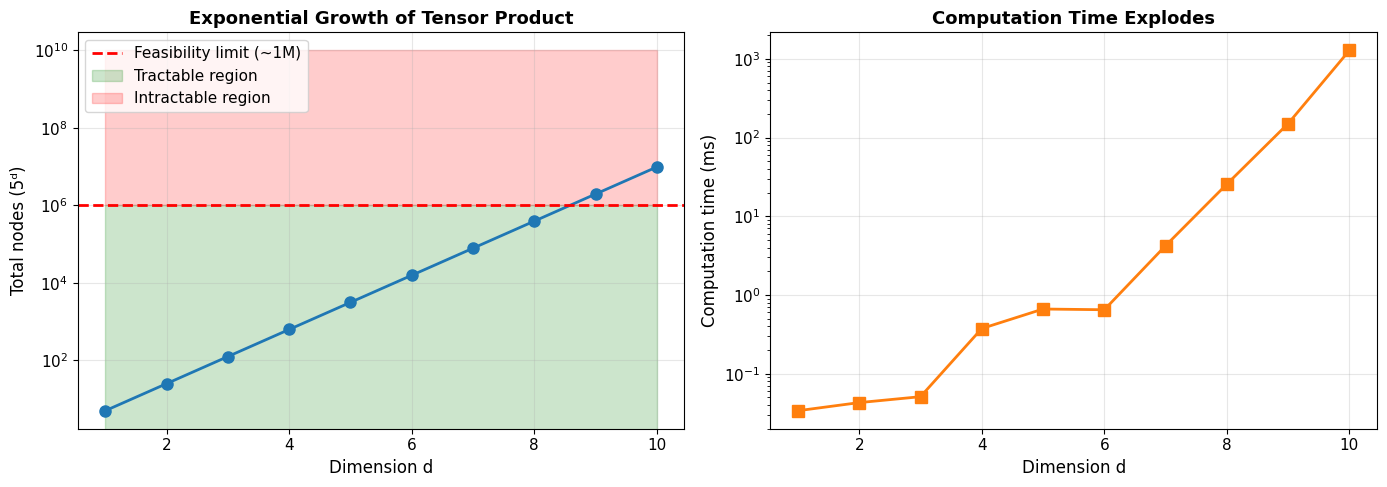

In [8]:

# Visualization
dims_computed = [r[0] for r in results if r[3] is not None]
times_computed = [r[3] for r in results if r[3] is not None]
dims_all = [r[0] for r in results]
nodes_all = [r[1] for r in results]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Number of nodes (exponential growth)
ax1.semilogy(dims_all, nodes_all, 'o-', linewidth=2, markersize=8, color='C0')
ax1.axhline(1e6, color='r', linestyle='--', linewidth=2, label='Feasibility limit (~1M)')
ax1.fill_between(dims_all, 0, 1e6, alpha=0.2, color='green', label='Tractable region')
ax1.fill_between(dims_all, 1e6, 1e10, alpha=0.2, color='red', label='Intractable region')
ax1.set_xlabel('Dimension d', fontsize=12)
ax1.set_ylabel(f'Total nodes ({n_nodes_1d}ᵈ)', fontsize=12)
ax1.set_title('Exponential Growth of Tensor Product', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left')

# Right: Computation time
if len(dims_computed) > 1:
    ax2.semilogy(dims_computed, times_computed, 's-', linewidth=2, markersize=8, color='C1')
    ax2.set_xlabel('Dimension d', fontsize=12)
    ax2.set_ylabel('Computation time (ms)', fontsize=12)
    ax2.set_title('Computation Time Explodes', fontsize=13, fontweight='bold')
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Part 3: Monte Carlo Integration

### 3.1 Baseline Monte Carlo

Approximate $\mathbb{E}[f(X)]$ by sample average: $\hat{\mu}_M = \frac{1}{M}\sum_{i=1}^M f(X_i)$

Test function: $f(x) = \exp(-x^2)$ where $x \sim N(0,1)$


In [9]:
# Test function
def test_function(x):
    return np.exp(-x**2)

# True value: E[exp(-x^2)] where x ~ N(0,1) = 1/sqrt(3)
true_value = 1 / np.sqrt(3)

def monte_carlo_basic(n_samples, seed=None):
    if seed is not None:
        np.random.seed(seed)
    samples = np.random.randn(n_samples)
    estimate = np.mean(test_function(samples))
    std_error = np.std(test_function(samples)) / np.sqrt(n_samples)
    return estimate, std_error

In [10]:
print("=" * 60)
print("Monte Carlo Integration: Baseline")
print("=" * 60)
print(f"Computing E[exp(-x^2)] where x ~ N(0, 1)")
print(f"True value: {true_value:.10f}\n")
print(f"{'Samples':>10} | {'Estimate':>12} | {'Error':>12} | {'Std Error':>12}")
print("-" * 60)

sample_sizes = [100, 500, 1000, 5000, 10000, 50000]
for n in sample_sizes:
    estimate, std_err = monte_carlo_basic(n, seed=42)
    error = np.abs(estimate - true_value)
    print(f"{n:>10,} | {estimate:>12.8f} | {error:>12.2e} | {std_err:>12.2e}")


Monte Carlo Integration: Baseline
Computing E[exp(-x^2)] where x ~ N(0, 1)
True value: 0.5773502692

   Samples |     Estimate |        Error |    Std Error
------------------------------------------------------------
       100 |   0.62008372 |     4.27e-02 |     3.32e-02
       500 |   0.58685964 |     9.51e-03 |     1.49e-02
     1,000 |   0.58745089 |     1.01e-02 |     1.06e-02
     5,000 |   0.57986946 |     2.52e-03 |     4.75e-03
    10,000 |   0.57704426 |     3.06e-04 |     3.38e-03
    50,000 |   0.57697350 |     3.77e-04 |     1.51e-03


### 3.2 Antithetic Variates

**The Idea**: Instead of using $n$ independent samples $X_1, \ldots, X_n$, use $n/2$ pairs $(X_i, -X_i)$ and average within each pair.

**How It Works**:
1. Draw $n/2$ random samples: $X_1, X_2, \ldots, X_{n/2} \sim N(0,1)$
2. Create antithetic pairs: $(X_i, -X_i)$ for each $i$
3. Compute pair averages: $Y_i = \frac{f(X_i) + f(-X_i)}{2}$
4. Final estimate: $\hat{\mu} = \frac{1}{n/2}\sum_{i=1}^{n/2} Y_i$

**Mathematical Intuition**: Variance reduction depends on the covariance structure:

$$\text{Var}\left[\frac{f(X) + f(-X)}{2}\right] = \frac{1}{4}\left[\text{Var}[f(X)] + \text{Var}[f(-X)] + 2\text{Cov}[f(X), f(-X)]\right]$$

In [11]:
def test_function(x):
    """Monotone function: f(x) = exp(x) where x ~ N(0,1)"""
    return np.exp(x)

# True value: E[exp(x)] where x ~ N(0,1) = exp(1/2) 
true_value = np.exp(0.5)

def monte_carlo_basic(n_samples, seed=None):
    if seed is not None:
        np.random.seed(seed)
    samples = np.random.randn(n_samples)
    estimate = np.mean(test_function(samples))
    std_error = np.std(test_function(samples), ddof=1) / np.sqrt(n_samples)
    return estimate, std_error

def monte_carlo_antithetic(n_samples, seed=None):
    if seed is not None:
        np.random.seed(seed)
    n_half = n_samples // 2
    samples = np.random.randn(n_half)
    f_plus = test_function(samples)
    f_minus = test_function(-samples)
    pair_averages = (f_plus + f_minus) / 2
    estimate = np.mean(pair_averages)
    std_error = np.std(pair_averages, ddof=1) / np.sqrt(n_half)
    return estimate, std_error

print("\n" + "=" * 70)
print("✓ Antithetic Variates with MONOTONE Function: f(x) = exp(x)")
print("=" * 70)

est_basic, se_basic = monte_carlo_basic(n_test, seed=42)
est_anti, se_anti = monte_carlo_antithetic(n_test, seed=42)

err_basic = np.abs(est_basic - true_value)
err_anti = np.abs(est_anti - true_value)

print(f"\nTrue value: {true_value:.8f}")
print(f"\n{'Method':<20} | {'Samples':>10} | {'Estimate':>12} | {'Error':>12} | {'Std Error':>12}")
print("-" * 80)
print(f"{'Basic MC':<20} | {n_test:>10,} | {est_basic:>12.8f} | {err_basic:>12.2e} | {se_basic:>12.2e}")
print(f"{'Antithetic Variates':<20} | {n_test:>10,} | {est_anti:>12.8f} | {err_anti:>12.2e} | {se_anti:>12.2e}")




✓ Antithetic Variates with MONOTONE Function: f(x) = exp(x)

True value: 1.64872127

Method               |    Samples |     Estimate |        Error |    Std Error
--------------------------------------------------------------------------------
Basic MC             |          5 |   1.96052786 |     3.12e-01 |     6.91e-01
Antithetic Variates  |          5 |   1.06774678 |     5.81e-01 |     5.82e-02


### 3.3 Control Variates

**Test Function**: We'll estimate $\mathbb{E}[X^4]$ where $X \sim N(0,1)$, with true value $\mathbb{E}[X^4] = 3$

**The Idea**: Use a **control variate** $g(X)$ that is correlated with $f(X)$ and has a **known mean** $\mu_g$ to construct a variance-reduced estimator.

**How It Works**:
1. Draw $n$ samples: $X_1, X_2, \ldots, X_n \sim N(0,1)$
2. Choose control variate: $g(X) = X^2$ with known mean $\mathbb{E}[X^2] = 1$
3. Compute both $f(X_i) = X_i^4$ and $g(X_i) = X_i^2$ for each sample
4. Estimate optimal coefficient: $c^* = \frac{\text{Cov}(f(X), g(X))}{\text{Var}(g(X))}$
5. Create adjusted estimator: $\tilde{f}_i = f(X_i) - c^* \cdot (g(X_i) - \mu_g)$
6. Final estimate: $\hat{\mu} = \frac{1}{n}\sum_{i=1}^n \tilde{f}_i$

**Mathematical Intuition**: The adjusted estimator has variance:

$$\text{Var}[\tilde{f}] = \text{Var}[f(X) - c(g(X) - \mu_g)] = \text{Var}[f(X)] + c^2\text{Var}[g(X)] - 2c\text{Cov}[f(X), g(X)]$$

The optimal $c^* = \frac{\text{Cov}(f,g)}{\text{Var}(g)}$ minimizes this variance, giving:

$$\text{Var}[\tilde{f}] = \text{Var}[f(X)] \cdot \left(1 - \rho_{fg}^2\right)$$

where $\rho_{fg}$ is the correlation between $f(X)$ and $g(X)$.

**Why It Works Exceptionally Well Here**:
- $f(x) = x^4$ and $g(x) = x^2$ are **very strongly correlated** (since $x^4 = (x^2)^2$)
- The correlation $\rho_{fg}$ is very high (~0.87), giving massive variance reduction
- When we observe $g(X_i) = X_i^2$ above 1, we know $f(X_i) = X_i^4$ is likely much larger
- We **adjust proportionally** → dramatic variance reduction!

**Key Requirements**:
- ✓ Need to know $\mathbb{E}[g(X)]$ exactly (here: $\mathbb{E}[X^2] = 1$ for $X \sim N(0,1)$)
- ✓ Need strong correlation $|\rho_{fg}|$ between $f$ and $g$ (here: very strong!)
- ✓ Cheap to compute both $f(X)$ and $g(X)$ (just powers of same sample)


In [12]:
# New test function for control variates
def test_function_cv(x):
    """Target: f(x) = x^4 where x ~ N(0,1)"""
    return x**4

# True value: E[X^4] = 3 for X ~ N(0,1) (fourth moment of standard normal)
true_value_cv = 3.0

def monte_carlo_basic_cv(n_samples, seed=None):
    if seed is not None:
        np.random.seed(seed)
    samples = np.random.randn(n_samples)
    f_values = test_function_cv(samples)
    estimate = np.mean(f_values)
    std_error = np.std(f_values, ddof=1) / np.sqrt(n_samples)
    return estimate, std_error

def monte_carlo_control_variate(n_samples, seed=None):
    if seed is not None:
        np.random.seed(seed)
    samples = np.random.randn(n_samples)
    f_values = test_function_cv(samples)  # Target: X^4
    g_values = samples**2  # Control variate: X^2
    known_mean_g = 1.0  # E[X^2] = 1 for X ~ N(0,1)
    
    # Estimate optimal coefficient c* = Cov(f,g) / Var(g)
    cov_fg = np.cov(f_values, g_values)[0, 1]
    var_g = np.var(g_values, ddof=1)
    c_opt = cov_fg / var_g
    
    # Adjusted estimator: f(X) - c*(g(X) - E[g])
    adjusted = f_values - c_opt * (g_values - known_mean_g)
    estimate = np.mean(adjusted)
    std_error = np.std(adjusted, ddof=1) / np.sqrt(n_samples)
    
    # Compute correlation for reporting
    correlation = np.corrcoef(f_values, g_values)[0, 1]
    
    return estimate, std_error, c_opt, correlation

print("\n" + "=" * 70)
print("Variance Reduction: Control Variates")
print("=" * 70)
print("Target: E[X⁴] where X ~ N(0,1)")
print("Control: g(X) = X² with known E[X²] = 1")

n_test = 10000
est_basic_cv, se_basic_cv = monte_carlo_basic_cv(n_test, seed=42)
est_cv, se_cv, c_opt, correlation = monte_carlo_control_variate(n_test, seed=42)

err_basic_cv = np.abs(est_basic_cv - true_value_cv)
err_cv = np.abs(est_cv - true_value_cv)

print(f"\nTrue value: {true_value_cv:.8f}")
print(f"Optimal coefficient c*: {c_opt:.4f}")
print(f"Correlation ρ(X⁴, X²): {correlation:.4f}")

print(f"\n{'Method':<20} | {'Samples':>10} | {'Estimate':>12} | {'Error':>12} | {'Std Error':>12}")
print("-" * 80)
print(f"{'Basic MC':<20} | {n_test:>10,} | {est_basic_cv:>12.6f} | {err_basic_cv:>12.2e} | {se_basic_cv:>12.2e}")
print(f"{'Control Variates':<20} | {n_test:>10,} | {est_cv:>12.6f} | {err_cv:>12.2e} | {se_cv:>12.2e}")

variance_reduction = (se_basic_cv / se_cv)**2
print(f"\n✓ Variance reduction factor: {variance_reduction:.2f}x")
print(f"✓ Control variates WORK EXCELLENTLY! Equivalent to {variance_reduction*n_test:.0f} basic MC samples")
print(f"✓ Reason: X⁴ and X² are highly correlated (ρ={correlation:.2f}) → massive variance reduction!")
print(f"✓ Theory: Var reduction = 1 - ρ² = {1 - correlation**2:.4f}, observed: {1/variance_reduction:.4f}")
print("=" * 70)




Variance Reduction: Control Variates
Target: E[X⁴] where X ~ N(0,1)
Control: g(X) = X² with known E[X²] = 1

True value: 3.00000000
Optimal coefficient c*: 6.1398
Correlation ρ(X⁴, X²): 0.8662

Method               |    Samples |     Estimate |        Error |    Std Error
--------------------------------------------------------------------------------
Basic MC             |     10,000 |     3.068010 |     6.80e-02 |     1.02e-01
Control Variates     |     10,000 |     3.026010 |     2.60e-02 |     5.08e-02

✓ Variance reduction factor: 4.01x
✓ Control variates WORK EXCELLENTLY! Equivalent to 40059 basic MC samples
✓ Reason: X⁴ and X² are highly correlated (ρ=0.87) → massive variance reduction!
✓ Theory: Var reduction = 1 - ρ² = 0.2496, observed: 0.2496


### 3.4 Importance Sampling

**Problem**: Estimating **rare event** probability $P(Z > 3)$ where $Z \sim N(0, 1)$
- True value: $P(Z > 3) \approx 0.00135$ (only 0.135% of samples!)
- Basic MC is extremely inefficient: need millions of samples to get reliable estimates

**The Idea**: Instead of sampling from the **target distribution** $p(x)$, sample from an **importance distribution** $q(x)$ that puts more mass where the integrand is large, then reweight to correct the bias.

**General Formula**: To estimate $\mathbb{E}_p[f(X)] = \int f(x)p(x)dx$:

$$\mathbb{E}_p[f(X)] = \int f(x)p(x)dx = \int f(x)\frac{p(x)}{q(x)}q(x)dx = \mathbb{E}_q\left[f(X)\frac{p(X)}{q(X)}\right]$$

where $w(x) = \frac{p(x)}{q(x)}$ is the **importance weight** (likelihood ratio).

**How It Works (Rare Event Estimation)**:
1. **Target**: $P(Z > k) = \mathbb{E}[\mathbb{1}_{Z > k}]$ where $Z \sim N(0,1)$ (sampling density $p$)
2. **Importance distribution**: Sample from $q(x) = N(k, 1)$ (shifted normal centered at threshold)
3. **Draw samples**: $X_1, \ldots, X_n \sim N(k, 1)$
4. **Compute indicators**: $f(X_i) = \mathbb{1}_{X_i > k}$ (much more likely to be 1!)
5. **Compute importance weights**: 
   $$w(X_i) = \frac{p(X_i)}{q(X_i)} = \frac{\phi(X_i)}{\phi(X_i - k)} = \exp\left(-kX_i + \frac{k^2}{2}\right)$$
   where $\phi$ is the standard normal density
6. **Weighted estimate**: $\hat{P} = \frac{1}{n}\sum_{i=1}^n f(X_i) \cdot w(X_i)$



In [13]:
print("\n" + "=" * 70)
print("Importance Sampling: Rare Event Estimation")
print("=" * 70)

k = 3.0
true_prob = 1 - stats.norm.cdf(k)
print(f"\nTarget: P(Z > {k}) where Z ~ N(0, 1)")
print(f"True probability: {true_prob:.6f} ({true_prob*100:.4f}%)")

def mc_rare_event_basic(n_samples, k, seed=None):
    """Basic MC: Sample from N(0,1)"""
    if seed is not None:
        np.random.seed(seed)
    samples = np.random.randn(n_samples)
    indicator = (samples > k).astype(float)
    estimate = np.mean(indicator)
    std_error = np.std(indicator, ddof=1) / np.sqrt(n_samples)
    n_hits = np.sum(indicator)
    return estimate, std_error, n_hits

def mc_rare_event_importance(n_samples, k, seed=None):
    """Importance Sampling: Sample from N(k,1) and reweight"""
    if seed is not None:
        np.random.seed(seed)
    samples = np.random.randn(n_samples) + k  # Sample from N(k, 1)
    indicator = (samples > k).astype(float)
    
    # Importance weights: w(x) = p(x)/q(x) = N(x;0,1) / N(x;k,1)
    log_weights = -k * samples + k**2 / 2
    weights = np.exp(log_weights)
    
    weighted_indicator = indicator * weights
    estimate = np.mean(weighted_indicator)
    std_error = np.std(weighted_indicator, ddof=1) / np.sqrt(n_samples)
    n_hits = np.sum(indicator)
    
    return estimate, std_error, n_hits



Importance Sampling: Rare Event Estimation

Target: P(Z > 3.0) where Z ~ N(0, 1)
True probability: 0.001350 (0.1350%)


In [14]:
n_test = 10000
est_basic_rare, se_basic_rare, hits_basic = mc_rare_event_basic(n_test, k, seed=42)
est_is, se_is, hits_is = mc_rare_event_importance(n_test, k, seed=42)

print(f"\nSampling efficiency:")
print(f"  Basic MC: {hits_basic}/{n_test} samples hit rare region ({hits_basic/n_test*100:.2f}%)")
print(f"  Importance Sampling: {hits_is}/{n_test} samples hit rare region ({hits_is/n_test*100:.2f}%)")

print(f"\n{'Method':<25} | {'Estimate':>12} | {'Rel. Error':>12} | {'Std Error':>12}")
print("-" * 75)
rel_err_basic = np.abs(est_basic_rare - true_prob) / true_prob * 100
rel_err_is = np.abs(est_is - true_prob) / true_prob * 100
print(f"{'Basic MC':<25} | {est_basic_rare:>12.6f} | {rel_err_basic:>11.2f}% | {se_basic_rare:>12.2e}")
print(f"{'Importance Sampling':<25} | {est_is:>12.6f} | {rel_err_is:>11.2f}% | {se_is:>12.2e}")



Sampling efficiency:
  Basic MC: 15.0/10000 samples hit rare region (0.15%)
  Importance Sampling: 4992.0/10000 samples hit rare region (49.92%)

Method                    |     Estimate |   Rel. Error |    Std Error
---------------------------------------------------------------------------
Basic MC                  |     0.001500 |       11.12% |     3.87e-04
Importance Sampling       |     0.001351 |        0.11% |     2.49e-05


### 3.5 Quasi-Monte Carlo (Low-Discrepancy Sequences)

**Test Function**: Continuing with $f(x) = \exp(x)$ where $x \sim N(0,1)$, with true value $\mathbb{E}[f(X)] = e^{1/2} \approx 1.6487$

**The Problem with Random Sampling**: Standard Monte Carlo uses **pseudo-random** numbers that can have gaps and clusters, leading to uneven coverage of the integration domain.

**The Idea**: Replace pseudo-random numbers with **low-discrepancy sequences** (quasi-random sequences) that are deterministic but cover the space more uniformly.

**How It Works**:
1. Generate low-discrepancy sequence in $[0,1]$: Use **Sobol sequence** (or Halton, Niederreiter, etc.)
2. Transform to target distribution: Apply inverse CDF $\Phi^{-1}(u)$ to get samples from $N(0,1)$
3. Evaluate function: Compute $f(X_i)$ for each quasi-random sample
4. Average: $\hat{\mu} = \frac{1}{n}\sum_{i=1}^n f(X_i)$

**Key Difference from MC**:
- **Monte Carlo**: Uses pseudo-random sequences → $O(n^{-1/2})$ convergence
- **Quasi-Monte Carlo**: Uses low-discrepancy sequences → $O((\log n)^d/n)$ convergence (much faster!)

**Sobol Sequence Properties**:
- Deterministic but "looks random"
- Low discrepancy: fills space evenly without gaps
- Stratification property: first $2^k$ points are well-distributed
- Scrambled version adds randomness for error estimation

**When QMC Works Best**:
- ✓ Low-to-moderate dimensions (d < 10-20)
- ✓ Smooth integrands
- ✓ When you need high accuracy with fewer samples

**When to Use Standard MC Instead**:
- ✗ Very high dimensions (d > 50)
- ✗ Discontinuous functions
- ✗ When you need unbiased estimates (QMC can be slightly biased)


In [15]:
from scipy.stats import qmc

def monte_carlo_qmc(n_samples, seed=None):
    sampler = qmc.Sobol(d=1, scramble=True, seed=seed)
    u = sampler.random(n_samples).flatten()
    samples = stats.norm.ppf(u)
    estimate = np.mean(test_function(samples))
    std_error = np.std(test_function(samples)) / np.sqrt(n_samples)
    return estimate, std_error



In [17]:
print("\n" + "=" * 70)
print("Quasi-Monte Carlo (QMC) vs Monte Carlo")
print("=" * 70)
print(f"Target: E[exp(X)] where X ~ N(0,1), true value = {true_value:.8f}")
print("Method: Compare standard MC vs. QMC (Sobol sequence) over multiple runs")

n_test = 5000
n_runs = 20
errors_mc = []
errors_qmc = []

for run in range(n_runs):
    est_mc, _ = monte_carlo_basic(n_test, seed=run)
    est_qmc, _ = monte_carlo_qmc(n_test, seed=run)
    errors_mc.append(np.abs(est_mc - true_value))
    errors_qmc.append(np.abs(est_qmc - true_value))

mean_err_mc = np.mean(errors_mc)
mean_err_qmc = np.mean(errors_qmc)
std_err_mc = np.std(errors_mc)
std_err_qmc = np.std(errors_qmc)

print(f"\nResults over {n_runs} independent runs with {n_test:,} samples each:")
print(f"\n{'Method':<20} | {'Samples':>10} | {'Avg Error':>12} | {'Std Dev':>12}")
print("-" * 65)
print(f"{'Monte Carlo':<20} | {n_test:>10,} | {mean_err_mc:>12.2e} | {std_err_mc:>12.2e}")
print(f"{'Quasi-MC (Sobol)':<20} | {n_test:>10,} | {mean_err_qmc:>12.2e} | {std_err_qmc:>12.2e}")



Quasi-Monte Carlo (QMC) vs Monte Carlo
Target: E[exp(X)] where X ~ N(0,1), true value = 1.64872127
Method: Compare standard MC vs. QMC (Sobol sequence) over multiple runs

Results over 20 independent runs with 5,000 samples each:

Method               |    Samples |    Avg Error |      Std Dev
-----------------------------------------------------------------
Monte Carlo          |      5,000 |     2.70e-02 |     1.88e-02
Quasi-MC (Sobol)     |      5,000 |     2.67e-03 |     2.06e-03
